# Lab 5: Vectori si valori proprii. Metoda Puterii si Metoda Puterii Inverse.
## Aplicatia: Google PageRank

**Introducere**

Când *Google* a devenit activ la sfârșitul anilor 1990, s-a remarcat față de alte motoare de căutare prin faptul că afișa* cele mai relevante rezultate* în primele poziții. Alte motoare de căutare ofereau adesea liste lungi de linkuri irelevante. Secretul **succesului Google** consta în **algoritmul PageRank**, dezvoltat de Sergey Brin și Larry Page. Acesta reprezintă un punct de referință în domeniul motoarelor de căutare, clasificând paginile web în funcție de importanța lor și folosind structura de legături dintre ele. PageRank utilizează metode de algebră liniară, în special calculul vectorilor proprii ai unei matrice stocastice, pentru a atribui fiecărei pagini un scor de relevanță.

### Concepte de baza

Problema Google, sau algoritmul PageRank, are scopul de a calcula **importanța relativă a paginilor web** într-o rețea de pagini interconectate.

**Cum cuantificam importanta paginilor web?**
Printr-un scor, pozitiv, ce deriva din conexiunile paginilor.
Astfel modelam  reteaua web ca un graf orientat, unde:
*  Fiecare **pagină web** este reprezentată de un **nod**.
*  Fiecare **legătură (link)** dintre pagini este reprezentată de un **arc**

Prin urmare definim:
*  $x_k$  pentru a reprezenta scorul de importanță al paginii  $k$, unde $x_k \geq 0$ .
* $ x_j >x_k$ înseamnă că pagina $ j $ este mai importantă decât pagina $ k$
* $x_j = 0 $ indică importanța minimă.

Prin urmare o legătură către pagina  $k$  devine un vot pentru importanța paginii $ k $.

#### Crearea unui graf in python

Vom folosi [gnp_random_graph](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html) pentru a genera un graf orientat cu $N$ noduri în care:

*  Fiecare nod are același număr de legături de ieșire, $k$

*  Numărul de legături de intrare variază moderat (controlat de parametrul alpha).

*  Legăturile multiple sunt permise.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
# ------------- PAARAMETRI -------------
n1, p1 = 3, 0.7   # Subretea 1: nr de noduri, probabilitatea unui arc
n2, p2 = 3, 0.8   # Subretea 2: nr de noduri, probabilitatea unui arc
N = n1+n2         #
# --------------------------------------
# GENERAREA UNEI RETELE CU 2 SUBRETELE
# --------------------------------------

# Generarea unui graf orientat aleator pentru subreteaua 1
G1 = nx.gnp_random_graph(n1, p1, directed=True)
G1 = nx.relabel_nodes(G1, lambda x: f"A{x}")  # Redenumeste nodurile A0, A1, …

# Generarea unui graf orientat aleator pentru subreteaua 2
G2 = nx.gnp_random_graph(n2, p2, directed=True)
G2 = nx.relabel_nodes(G2, lambda x: f"B{x}")  # Redenumeste nodurile B0, B1, …

# Cobina cele doua grafuri intr-o singura retea (graf)
G = nx.DiGraph()
G.update(G1)
G.update(G2)

##### Afisare graf

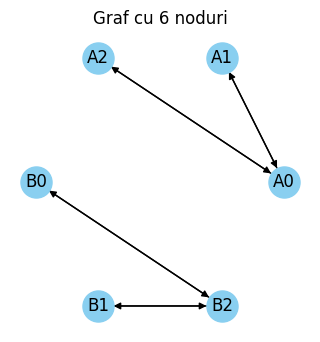

In [8]:
plt.figure(figsize=(3, 3))
nx.draw_circular(G, node_size=500, node_color="#89CFF0", with_labels=True)
plt.title(f'Graf cu {N} noduri')
plt.show()

#### Formularea problemei

**Matricea de adiacenta** este o modalitate de a **reprezenta un graf (rețea)** folosind o matrice numerică. Pentru un graf cu $N$ noduri, matricea de adiacență $A$ este o matrice $N × N$ în care:
* $A[i][j] = \begin{cases} 1, & \text{daca există o muchie din $i$ către $j$}\\
0, &\text{altfel}
\end{cases}$

In grafurile ponderate se pune pe pozitia $(i,j)$ valoarea ponderei utilizate daca exista muchie.


In [9]:
A = nx.to_numpy_array(G)
A

array([[0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1., 0.]])

**Crearea matricei stocastice**

**Def:** O matrice patratica se numeste **matrice stochastica** pe coloane daca toate *elementele* sale sunt *pozitive*, iar **intrarile din fiecare coloana insumeaza unu**.

*Interpretarea: In matricea stocatica, fiecare coloană $j$ reprezintă o distribuție de probabilitate, mai exact probabilitatea de a trece de la pagina $j$ la pagina $i$*

**Propozitie**: Orice matrice $A$ stocastica pe coloane are o valoare proprie egala cu 1:
$A x = x,$ unde $x \neq 0$ este vectorul propriu.

*Interpretarea: Vectorul propriu asociat valorii proprii 1 reprezinta scorurile pentru fiecare nod.*


In [10]:
A /=A.sum(axis = 0)
A

array([[0. , 1. , 1. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 1. , 1. , 0. ]])

**Aceasta formulare are doua neajunsuri:**
*  **Retelele web cu mai multe subretele:** aceste retele nu au un clasament unic, i.e exista mai multi vectori proprii asociati valorii proprii 1, cu proprietatea $\sum_i x_i=1$.

  *Intuitiv, daca o retea contine $r$ subretele atunci ar fi de așteptat să fie dificil să se găsească un cadru de referință comun pentru compararea scorurilor paginilor dintr-o subrețea cu cele dintr-o altă subrețea.*

*  **Retele web cu noduri suspendate:** in acest caz valorile proprii sunt mai mici decat 1.

Remediul pentru aceste neajunsuri: Vom utiliza o matrice de medie ce se bazeaza pe matricea de adiacenta A stocastica.

**Calcularea matricei medii M**


Pentru o rețea web cu $n$ pagini, fără noduri terminale (dangling nodes), putem genera scoruri de importanță neambigue astfel:

 Fie $S$ o matrice $N \times N$ în care toate elementele sunt egale cu $1/N$. Matricea $S$ este stocastica pe coloane.
 In cele ce urmeaza vom calcula vectorul propriu asociat valorii proprii dominante $1$ pentru matricea de medii $M$ :

$$ M = (1 - p)A + pS, $$

unde $0 \leq p \leq 1$.

Matricea $M$ este o medie ponderată între $A$ și $S$. Valoarea lui $p$ utilizată inițial de Google este raportată ca fiind $0.15$. Pentru orice $p \in [0, 1]$, matricea $M$ este stocastica pe coloane, și se poate arata ca are vector propriu unic asociat valorii proprii 1, dacă $p \in (0, 1]$.

In [50]:
S = np.ones((N,N))/N
m = 0.15
M = (1 - m) * A + m * S
M

array([[0.025, 0.875, 0.875, 0.025, 0.025, 0.025],
       [0.45 , 0.025, 0.025, 0.025, 0.025, 0.025],
       [0.45 , 0.025, 0.025, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.025, 0.025, 0.45 ],
       [0.025, 0.025, 0.025, 0.025, 0.025, 0.45 ],
       [0.025, 0.025, 0.025, 0.875, 0.875, 0.025]])

## [Cerinte]:
Aplicati metoda puterii si metoda puterii inverse (aveti pseudocodurile in lab 5 pe moodle) pe matricea medie $M$.

1. Afisati intr-un grafic eroarea (criteriul de oprire) de-a lungul iteratiilor pentru metoda puterii si metoda puterii inverse. Utilizati functia [semilogy](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogy.html)
2. Afisati un al doilea grafic eroarea de a lungul timpului pentru ambele metode.
3. Afisati valoare proprie calculata pe baza vectorului propriu.
4. Comentati rezultatele
5. Afisati nodurile in functie de importanta lor (i.e scorurile obtinute)

Pentru o comparatie corecta porniti cu aceeași valoare initiala pentru vectorul propriu.

**Bibliografie:**
Kurt Bryan  and Tanya Leise. *"The \$ 25,000,000,000 eigenvector: The linear algebra behind Google."*  SIAM review 48, no. 3 (2006): 569-581.


In [19]:
import time

In [24]:
def power_method(A, tol, max_iter, y_init=None):
  n = A.shape[0]
  
  # 1. Se alege aleator un vector y
  if y_init is None:
    np.random.seed(0)
    y = np.random.rand(n)
  else:
    y = y_init.copy()
      
  # 2. Normalizam vectorul y
  y = y / np.linalg.norm(y)
  
  # 3.
  i = 0
  e = 1.0
  errors = []
  times = [] # List pentru a stoca timpul
  
  start_time = time.time() # Start cronometru
  
  # 4. cat timp e > tol
  while e > tol:
    # 4.1 daca i > max_iter
    if i > max_iter:
      print('S-a atins numarul maxim de iteratii (PM).')
      break
    
    # 4.2 z = Ay
    z = A @ y
    
    # 4.3 Normalizam z
    z = z / np.linalg.norm(z)

    # 4.4 Calculam eroarea
    e = np.abs(1 - np.abs(z.T @ y))
    
    # Stocam eroarea si timpul curent
    current_time = time.time() - start_time
    errors.append(e)
    times.append(current_time)
    
    # 4.5
    y = z
      
    # 4.6
    i += 1
        
  return y, errors, times

In [25]:
def inverse_power_method(A, tol, max_iter, y_init=None):
  n = A.shape[0]
  I = np.eye(n)

  # 1. Se alege aleator un vector y
  if y_init is None:
    np.random.seed(0)
    y = np.random.rand(n)
  else:
    y = y_init.copy()
      
  # 2. Normalizam vectorul y
  y = y / np.linalg.norm(y)
  
  # 3. 
  i = 0
  e = 1.0
  errors = []
  times = [] # List pentru a stoca timpul
  
  start_time = time.time() # Start cronometru
  
  # 4. cat timp e > tol
  while e > tol:
    # 4.1 daca i > max_iter
    if i > max_iter:
      print('S-a atins numarul maxim de iteratii (IPM).')
      break
        
    # 4.2 miu = y^T A y
    miu = y.T @ A @ y

    # 4.3 (miu*I - A)z = y
    matrix_to_solve = miu * I - A
    
    try:
        z = np.linalg.solve(matrix_to_solve, y)
    except np.linalg.LinAlgError:
        print("Matrice singulara intalnita. Stop.")
        break

    # 4.4 Normalizam z
    z = z / np.linalg.norm(z)

    # 4.5 Calculam eroarea
    e = np.abs(1 - np.abs(z.T @ y))

    # Stocam eroarea si timpul curent
    current_time = time.time() - start_time
    errors.append(e)
    times.append(current_time)
    
    # 4.6
    y = z

    # 4.7
    i += 1
    
  return y, errors, times

### Cerinta 1
Afisati intr-un grafic eroarea (criteriul de oprire) de-a lungul iteratiilor pentru metoda puterii si metoda puterii inverse. Utilizati functia [semilogy](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogy.html)

#### Cerinta 2
Afisati un al doilea grafic eroarea de a lungul timpului pentru ambele metode.

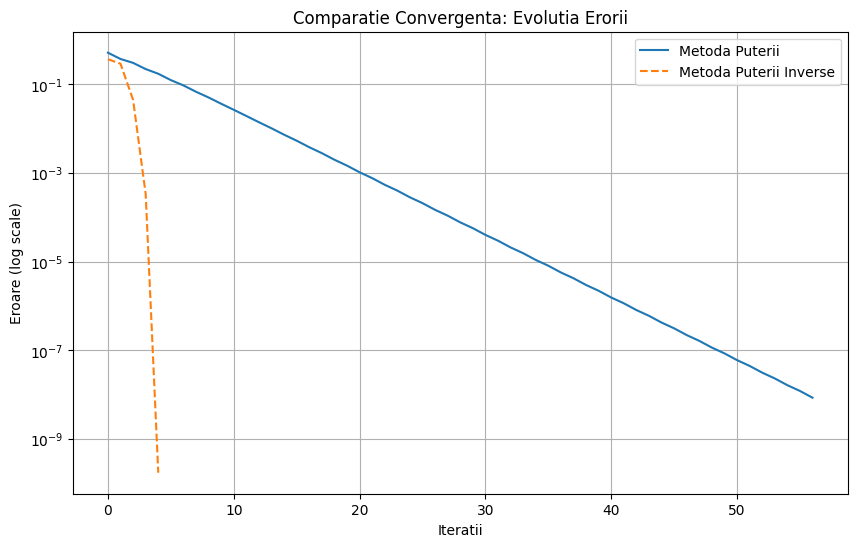

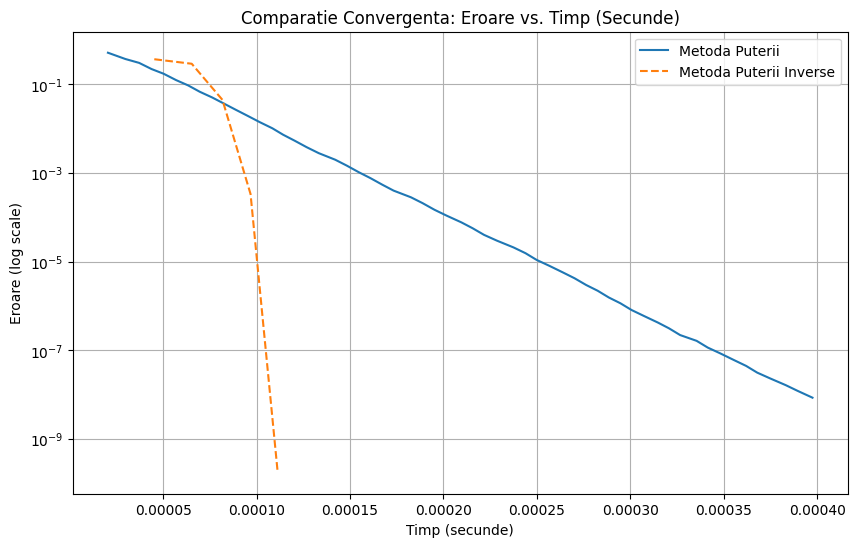

In [46]:
# Luam y aleator
np.random.seed(42)
y0 = np.random.rand(N)

tol = 1e-8
max_iter = 1000

# Metoda Puterii
y_pm, errors_pm, times_pm = power_method(M, tol, max_iter, y_init=y0)

# Metoda Puterii Inverse
y_ipm, errors_ipm, times_ipm = inverse_power_method(M, tol, max_iter, y_init=y0)

plt.figure(figsize=(10, 6))

# Metoda Puterii Errors
plt.semilogy(range(len(errors_pm)), errors_pm, label='Metoda Puterii')

# Metoda Puterii Inverse Errors
plt.semilogy(range(len(errors_ipm)), errors_ipm, label='Metoda Puterii Inverse', linestyle='--')

plt.title('Comparatie Convergenta: Evolutia Erorii')
plt.xlabel('Iteratii')
plt.ylabel('Eroare (log scale)')
plt.grid(True)
plt.legend()
plt.show()

# Cerinta 2
plt.figure(figsize=(10, 6))

# Metoda Puterii
plt.semilogy(times_pm, errors_pm, label='Metoda Puterii')

# Metoda Puterii Inverse
plt.semilogy(times_ipm, errors_ipm, label='Metoda Puterii Inverse', linestyle='--')

plt.title('Comparatie Convergenta: Eroare vs. Timp (Secunde)')
plt.xlabel('Timp (secunde)')
plt.ylabel('Eroare (log scale)')
plt.grid(True)
plt.legend()
plt.show()

#### Cerinta 3
Afisati valoare proprie calculata pe baza vectorului propriu.

In [32]:
# Calculam valoarea proprie pentru vectorul rezultat din Metoda Puterii
lambda_pm = y_pm.T @ M @ y_pm

# Calculam valoarea proprie pentru vectorul rezultat din Metoda Puterii Inverse
lambda_ipm = y_ipm.T @ M @ y_ipm

print(f"Valoarea proprie calculata (Metoda Puterii): {lambda_pm:.6f}")
print(f"Valoarea proprie calculata (Metoda Puterii Inverse): {lambda_ipm:.6f}")
print(f"Valoarea teoretica asteptata: 1.000000")

Valoarea proprie calculata (Metoda Puterii): 0.999966
Valoarea proprie calculata (Metoda Puterii Inverse): 0.850000
Valoarea teoretica asteptata: 1.000000


#### Cerinta 4
Comentati rezultatele

- Metoda Puterii Inverse este mult mai eficienta ca numar de pasi. Ea ajunge la solutie aproape instantaneu (in 4-5 iteratii), pe cand Metoda Puterii coboara lent si constant, avand nevoie de aproape 60 de iteratii.
- Pentru acest exemplu mic (N = 50), Metoda Inversa este mai rapida chiar si in timp (aprox. 0.00017s față de 0.00085s).

#### Cerinta 5
Afisati nodurile in functie de importanta lor (i.e scorurile obtinute)

In [49]:
scores = y_pm / np.sum(y_pm) # Re-normalizare ca suma sa fie 1

# Sortam indicii descrescator dupa scor
ranked_indices = np.argsort(scores)[::-1]

print("Cele mai importante noduri (PageRank):")
print(f"{'Loc'} | {'Nod ID'} | {'Scor'}")

for rank, idx in enumerate(ranked_indices):
  print(f"{rank+1}   | {idx}      | {scores[idx]:.6f}")

Cele mai importante noduri (PageRank):
Loc | Nod ID | Scor
1   | 0      | 0.243273
2   | 5      | 0.243243
3   | 1      | 0.128373
4   | 2      | 0.128373
5   | 4      | 0.128369
6   | 3      | 0.128369
